In [27]:
from datetime import datetime
import pandas as pd
import numpy as np

import xgboost as xgb

btc_market = pd.read_csv('btc-pulse-data.csv') # source: https://www.kaggle.com/datasets/wlwwwlw/bitcoin-pulse-market-trends-and-fear-dataset 

In [28]:
btc_market['timestamp'] = pd.to_datetime(btc_market['timestamp'])

btc_market["Day"] = btc_market["timestamp"].dt.day.astype(str) 
btc_market["Month"] = btc_market["timestamp"].dt.month.astype(str)
btc_market["Year"] = btc_market["timestamp"].dt.year.astype(str)
btc_market["Time-in-date"] = btc_market["Year"] + "-" + btc_market["Month"] + "-" + btc_market["Day"]

btc_market.head()

,timestamp,BNB_USDT_1h_open,BNB_USDT_1h_high,BNB_USDT_1h_low,BNB_USDT_1h_close,BNB_USDT_1h_volume,BTC_USDT_1h_open,BTC_USDT_1h_high,BTC_USDT_1h_low,BTC_USDT_1h_close,...,fear_greed_index,trend_bitcoin,trend_buy_crypto,google_trends_bitcoin,google_trends_buy_crypto,open_interest,Day,Month,Year,Time-in-date
0,2023-04-09 00:00:00,310.5739,311.1801,310.4821,311.1801,28.717,27943.39,28073.95,27930.31,28035.04,...,61.0,38.0,17.0,38.0,17.0,8.142427e+09,9,4,2023,2023-4-9
1,2023-04-09 01:00:00,311.1801,311.6257,311.1489,311.6132,15.980,28035.04,28080.00,28029.69,28075.72,...,61.0,38.0,17.0,38.0,17.0,8.142427e+09,9,4,2023,2023-4-9
2,2023-04-09 02:00:00,311.6132,311.8623,311.2814,311.2814,37.265,28075.72,28080.84,28027.47,28033.86,...,61.0,38.0,17.0,38.0,17.0,8.142427e+09,9,4,2023,2023-4-9
3,2023-04-09 03:00:00,311.2814,311.4965,311.0072,311.2450,22.836,28033.86,28047.09,28019.16,28025.87,...,61.0,38.0,17.0,38.0,17.0,8.142427e+09,9,4,2023,2023-4-9
4,2023-04-09 04:00:00,311.2450,311.3736,311.0723,311.1659,44.535,28025.87,28038.02,28016.28,28036.28,...,61.0,38.0,17.0,38.0,17.0,8.142427e+09,9,4,2023,2023-4-9


In [29]:
btc_data = btc_market[["timestamp", "Time-in-date", "BTC_USDT_1h_open", "Open_nasdaq", "Open_russell_2000", "Open_vix", "Open_dow_jones", "Open_sp500", "fear_greed_index", "google_trends_bitcoin", "google_trends_buy_crypto", "open_interest", "btc_dominance", "altcoin_market_cap"]]
btc_data = btc_data.drop_duplicates(subset=["Time-in-date"])
btc_data.head()


,timestamp,Time-in-date,BTC_USDT_1h_open,Open_nasdaq,Open_russell_2000,Open_vix,Open_dow_jones,Open_sp500,fear_greed_index,google_trends_bitcoin,google_trends_buy_crypto,open_interest,btc_dominance,altcoin_market_cap
0,2023-04-09,2023-4-9,27943.39,11973.323242,1749.307251,19.389999,33425.250000,4085.199951,61.0,38.0,17.0,8.142427e+09,19.43,6.817052e+11
24,2023-04-10,2023-4-10,28320.00,11973.323242,1749.307251,19.389999,33425.250000,4085.199951,62.0,38.0,17.0,9.399080e+09,19.39,6.817052e+11
48,2023-04-11,2023-4-11,29639.20,12062.104492,1770.708130,19.000000,33513.261719,4100.140137,68.0,38.0,17.0,9.495525e+09,19.13,6.971717e+11
72,2023-04-12,2023-4-12,30201.23,12079.721680,1794.129639,18.570000,33766.031250,4122.299805,65.0,38.0,17.0,9.352708e+09,18.98,6.971717e+11
96,2023-04-13,2023-4-13,29883.65,11928.183594,1774.293823,18.740000,33604.191406,4088.419922,61.0,38.0,17.0,9.515774e+09,18.99,6.985889e+11


In [30]:
btc_data = btc_data.set_index("Time-in-date")
btc_data.head()

,timestamp,BTC_USDT_1h_open,Open_nasdaq,Open_russell_2000,Open_vix,Open_dow_jones,Open_sp500,fear_greed_index,google_trends_bitcoin,google_trends_buy_crypto,open_interest,btc_dominance,altcoin_market_cap
Time-in-date,,,,,,,,,,,,,
2023-4-9,2023-04-09,27943.39,11973.323242,1749.307251,19.389999,33425.250000,4085.199951,61.0,38.0,17.0,8.142427e+09,19.43,6.817052e+11
2023-4-10,2023-04-10,28320.00,11973.323242,1749.307251,19.389999,33425.250000,4085.199951,62.0,38.0,17.0,9.399080e+09,19.39,6.817052e+11
2023-4-11,2023-04-11,29639.20,12062.104492,1770.708130,19.000000,33513.261719,4100.140137,68.0,38.0,17.0,9.495525e+09,19.13,6.971717e+11
2023-4-12,2023-04-12,30201.23,12079.721680,1794.129639,18.570000,33766.031250,4122.299805,65.0,38.0,17.0,9.352708e+09,18.98,6.971717e+11
2023-4-13,2023-04-13,29883.65,11928.183594,1774.293823,18.740000,33604.191406,4088.419922,61.0,38.0,17.0,9.515774e+09,18.99,6.985889e+11


<Figure size 1200x600 with 0 Axes>

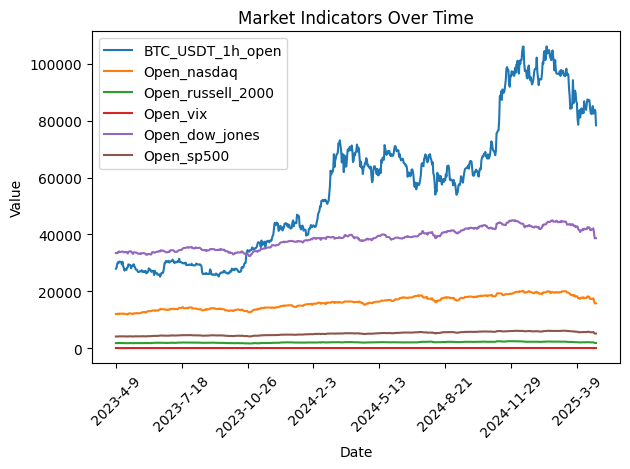

In [31]:
import matplotlib.pyplot as plt

# Create a figure with a larger size
plt.figure(figsize=(12, 6))

# Plot the data with a legend
btc_data[['BTC_USDT_1h_open', 'Open_nasdaq', 'Open_russell_2000', 'Open_vix', 'Open_dow_jones', 'Open_sp500']].plot()

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Market Indicators Over Time')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [32]:
btc_data[['BTC_USDT_1h_open', 'Open_nasdaq', 'Open_russell_2000', 'Open_vix', 'Open_dow_jones', 'Open_sp500', 'fear_greed_index', 'google_trends_bitcoin', 'google_trends_buy_crypto', 'open_interest', 'btc_dominance', 'altcoin_market_cap']].corr()

,BTC_USDT_1h_open,Open_nasdaq,Open_russell_2000,Open_vix,Open_dow_jones,Open_sp500,fear_greed_index,google_trends_bitcoin,google_trends_buy_crypto,open_interest,btc_dominance,altcoin_market_cap
BTC_USDT_1h_open,1.000000,0.932029,0.854069,0.163023,0.933793,0.935453,0.231232,0.600317,0.700718,0.966699,-0.236130,0.948389
Open_nasdaq,0.932029,1.000000,0.930424,0.073841,0.971335,0.994313,0.109189,0.453743,0.586108,0.905514,-0.245065,0.874624
Open_russell_2000,0.854069,0.930424,1.000000,-0.016539,0.946469,0.937014,0.206344,0.495607,0.638594,0.828640,-0.136251,0.829206
Open_vix,0.163023,0.073841,-0.016539,1.000000,0.126039,0.121630,-0.388983,0.018622,-0.068992,0.216309,-0.409342,-0.010301
Open_dow_jones,0.933793,0.971335,0.946469,0.126039,1.000000,0.985733,0.120732,0.499679,0.612864,0.900687,-0.223006,0.864479
Open_sp500,0.935453,0.994313,0.937014,0.121630,0.985733,1.000000,0.086093,0.456034,0.576357,0.903269,-0.255798,0.868637
fear_greed_index,0.231232,0.109189,0.206344,-0.388983,0.120732,0.086093,1.000000,0.483017,0.488428,0.167944,0.442655,0.385291
google_trends_bitcoin,0.600317,0.453743,0.495607,0.018622,0.499679,0.456034,0.483017,1.000000,0.830182,0.541907,0.071076,0.636500
google_trends_buy_crypto,0.700718,0.586108,0.638594,-0.068992,0.612864,0.576357,0.488428,0.830182,1.000000,0.697468,0.041464,0.743173
open_interest,0.966699,0.905514,0.828640,0.216309,0.900687,0.903269,0.167944,0.541907,0.697468,1.000000,-0.309856,0.881877


I'll help create a function to generate lagged features for our Bitcoin prediction model. Given the data we have, we'll create a function that can generate lagged values for our features.

In [33]:
def lagged_features(df, features, lag_periods=[1, 2]):

    df_copy = df.copy()
    
    for feature in features:
        for lag in lag_periods:
            lagged_name = f'{feature}_lag_{lag}'
            df_copy[lagged_name] = df_copy[feature].shift(lag)
    df_copy = df_copy.dropna()
    return df_copy


features_to_lag = ['BTC_USDT_1h_open', 'Open_nasdaq', 'Open_russell_2000', 
                  'Open_vix', 'Open_dow_jones', 'Open_sp500', 
                  'fear_greed_index', 'google_trends_bitcoin', 
                  'google_trends_buy_crypto', 'open_interest', 
                  'btc_dominance', 'altcoin_market_cap']

# Create lagged features with 1-day and 3-day lags
btc_data_lagged = lagged_features(btc_data, features_to_lag)



testing_data = btc_data[btc_data.timestamp.dt.year == 2025]
training_data = btc_data[btc_data.timestamp.dt.year < 2025]
train_data = lagged_features(training_data, features_to_lag, lag_periods=[1, 2])
test_data = lagged_features(testing_data, features_to_lag, lag_periods=[1, 2])

In [34]:
train_data.head()

,timestamp,BTC_USDT_1h_open,Open_nasdaq,Open_russell_2000,Open_vix,Open_dow_jones,Open_sp500,fear_greed_index,google_trends_bitcoin,google_trends_buy_crypto,...,google_trends_bitcoin_lag_1,google_trends_bitcoin_lag_2,google_trends_buy_crypto_lag_1,google_trends_buy_crypto_lag_2,open_interest_lag_1,open_interest_lag_2,btc_dominance_lag_1,btc_dominance_lag_2,altcoin_market_cap_lag_1,altcoin_market_cap_lag_2
Time-in-date,,,,,,,,,,,,,,,,,,,,,
2023-4-11,2023-04-11,29639.20,12062.104492,1770.708130,19.000000,33513.261719,4100.140137,68.0,38.0,17.0,...,38.0,38.0,17.0,17.0,9.399080e+09,8.142427e+09,19.39,19.43,6.817052e+11,6.817052e+11
2023-4-12,2023-04-12,30201.23,12079.721680,1794.129639,18.570000,33766.031250,4122.299805,65.0,38.0,17.0,...,38.0,38.0,17.0,17.0,9.495525e+09,9.399080e+09,19.13,19.39,6.971717e+11,6.817052e+11
2023-4-13,2023-04-13,29883.65,11928.183594,1774.293823,18.740000,33604.191406,4088.419922,61.0,38.0,17.0,...,38.0,38.0,17.0,17.0,9.352708e+09,9.495525e+09,18.98,19.13,6.971717e+11,6.971717e+11
2023-4-14,2023-04-14,30374.70,12171.472656,1798.477295,18.200001,34041.050781,4148.029785,68.0,38.0,17.0,...,38.0,38.0,17.0,17.0,9.515774e+09,9.352708e+09,18.99,18.98,6.985889e+11,6.971717e+11
2023-4-15,2023-04-15,30459.00,12102.560547,1775.362793,17.340000,33832.121094,4130.100098,68.0,38.0,17.0,...,38.0,38.0,17.0,17.0,8.867074e+09,9.515774e+09,19.14,18.99,6.985889e+11,6.985889e+11


In [35]:
useful_cols = [x for x in train_data if x not in ['Open_vix_lag_1', 'Open_vix_lag_2', 'fear_greed_index_lag_1', 'fear_greed_index_lag_2', 'google_trends_bitcoin_lag_1', 'google_trends_bitcoin_lag_2', 'google_trends_buy_crypto_lag_1', 'google_trends_buy_crypto_lag_2', 'btc_dominance_lag_1', 'btc_dominance_lag_2']]

In [36]:
train_data = train_data[useful_cols]
test_data = test_data[useful_cols]

In [37]:
train_data.head()

,timestamp,BTC_USDT_1h_open,Open_nasdaq,Open_russell_2000,Open_vix,Open_dow_jones,Open_sp500,fear_greed_index,google_trends_bitcoin,google_trends_buy_crypto,...,Open_russell_2000_lag_1,Open_russell_2000_lag_2,Open_dow_jones_lag_1,Open_dow_jones_lag_2,Open_sp500_lag_1,Open_sp500_lag_2,open_interest_lag_1,open_interest_lag_2,altcoin_market_cap_lag_1,altcoin_market_cap_lag_2
Time-in-date,,,,,,,,,,,,,,,,,,,,,
2023-4-11,2023-04-11,29639.20,12062.104492,1770.708130,19.000000,33513.261719,4100.140137,68.0,38.0,17.0,...,1749.307251,1749.307251,33425.250000,33425.250000,4085.199951,4085.199951,9.399080e+09,8.142427e+09,6.817052e+11,6.817052e+11
2023-4-12,2023-04-12,30201.23,12079.721680,1794.129639,18.570000,33766.031250,4122.299805,65.0,38.0,17.0,...,1770.708130,1749.307251,33513.261719,33425.250000,4100.140137,4085.199951,9.495525e+09,9.399080e+09,6.971717e+11,6.817052e+11
2023-4-13,2023-04-13,29883.65,11928.183594,1774.293823,18.740000,33604.191406,4088.419922,61.0,38.0,17.0,...,1794.129639,1770.708130,33766.031250,33513.261719,4122.299805,4100.140137,9.352708e+09,9.495525e+09,6.971717e+11,6.971717e+11
2023-4-14,2023-04-14,30374.70,12171.472656,1798.477295,18.200001,34041.050781,4148.029785,68.0,38.0,17.0,...,1774.293823,1794.129639,33604.191406,33766.031250,4088.419922,4122.299805,9.515774e+09,9.352708e+09,6.985889e+11,6.971717e+11
2023-4-15,2023-04-15,30459.00,12102.560547,1775.362793,17.340000,33832.121094,4130.100098,68.0,38.0,17.0,...,1798.477295,1774.293823,34041.050781,33604.191406,4148.029785,4088.419922,8.867074e+09,9.515774e+09,6.985889e+11,6.985889e+11


I've created a function `lagged_features` that generates lagged versions of specified features. The function:
1. Takes a DataFrame, list of features, and lag periods as input
2. Creates new columns with lagged values for each feature and lag period
3. Handles data cleaning by removing NaN values created by the lag operation
4. Returns the processed DataFrame

In the example usage, I applied 1-day and 2-day lags to all our numerical features. The resulting dataset now has 20 additional columns (10 features × 2 lag periods), which can be useful for time series analysis and prediction tasks.

In [38]:
test = test_data.drop(['Open_nasdaq', 'Open_russell_2000', 'Open_vix', 'Open_dow_jones', 'Open_sp500', 'fear_greed_index', 'google_trends_bitcoin', 'google_trends_buy_crypto', 'open_interest', 'btc_dominance', 'altcoin_market_cap'], axis=1)
train = train_data.drop(['Open_nasdaq', 'Open_russell_2000', 'Open_vix', 'Open_dow_jones', 'Open_sp500', 'fear_greed_index', 'google_trends_bitcoin', 'google_trends_buy_crypto', 'open_interest', 'btc_dominance', 'altcoin_market_cap'], axis=1)

In [39]:
train.head()

,timestamp,BTC_USDT_1h_open,BTC_USDT_1h_open_lag_1,BTC_USDT_1h_open_lag_2,Open_nasdaq_lag_1,Open_nasdaq_lag_2,Open_russell_2000_lag_1,Open_russell_2000_lag_2,Open_dow_jones_lag_1,Open_dow_jones_lag_2,Open_sp500_lag_1,Open_sp500_lag_2,open_interest_lag_1,open_interest_lag_2,altcoin_market_cap_lag_1,altcoin_market_cap_lag_2
Time-in-date,,,,,,,,,,,,,,,,
2023-4-11,2023-04-11,29639.20,28320.00,27943.39,11973.323242,11973.323242,1749.307251,1749.307251,33425.250000,33425.250000,4085.199951,4085.199951,9.399080e+09,8.142427e+09,6.817052e+11,6.817052e+11
2023-4-12,2023-04-12,30201.23,29639.20,28320.00,12062.104492,11973.323242,1770.708130,1749.307251,33513.261719,33425.250000,4100.140137,4085.199951,9.495525e+09,9.399080e+09,6.971717e+11,6.817052e+11
2023-4-13,2023-04-13,29883.65,30201.23,29639.20,12079.721680,12062.104492,1794.129639,1770.708130,33766.031250,33513.261719,4122.299805,4100.140137,9.352708e+09,9.495525e+09,6.971717e+11,6.971717e+11
2023-4-14,2023-04-14,30374.70,29883.65,30201.23,11928.183594,12079.721680,1774.293823,1794.129639,33604.191406,33766.031250,4088.419922,4122.299805,9.515774e+09,9.352708e+09,6.985889e+11,6.971717e+11
2023-4-15,2023-04-15,30459.00,30374.70,29883.65,12171.472656,11928.183594,1798.477295,1774.293823,34041.050781,33604.191406,4148.029785,4088.419922,8.867074e+09,9.515774e+09,6.985889e+11,6.985889e+11


In [40]:
train.corr()

,timestamp,BTC_USDT_1h_open,BTC_USDT_1h_open_lag_1,BTC_USDT_1h_open_lag_2,Open_nasdaq_lag_1,Open_nasdaq_lag_2,Open_russell_2000_lag_1,Open_russell_2000_lag_2,Open_dow_jones_lag_1,Open_dow_jones_lag_2,Open_sp500_lag_1,Open_sp500_lag_2,open_interest_lag_1,open_interest_lag_2,altcoin_market_cap_lag_1,altcoin_market_cap_lag_2
timestamp,1.000000,0.911257,0.910795,0.910361,0.966848,0.966844,0.882430,0.882511,0.953571,0.953445,0.972272,0.972232,0.877798,0.877585,0.821208,0.820299
BTC_USDT_1h_open,0.911257,1.000000,0.997529,0.995273,0.922172,0.921746,0.879298,0.880058,0.922445,0.923618,0.925584,0.925683,0.962368,0.959959,0.963408,0.959812
BTC_USDT_1h_open_lag_1,0.910795,0.997529,1.000000,0.997520,0.922220,0.921695,0.878716,0.879405,0.921288,0.922392,0.925351,0.925362,0.960309,0.962580,0.966474,0.963220
BTC_USDT_1h_open_lag_2,0.910361,0.995273,0.997520,1.000000,0.920977,0.921762,0.875492,0.878876,0.918903,0.921271,0.924038,0.925161,0.957858,0.960428,0.965142,0.966299
Open_nasdaq_lag_1,0.966848,0.922172,0.922220,0.920977,1.000000,0.997931,0.933647,0.930331,0.966509,0.965047,0.994292,0.992616,0.907203,0.907173,0.853278,0.851712
Open_nasdaq_lag_2,0.966844,0.921746,0.921695,0.921762,0.997931,1.000000,0.932498,0.933806,0.965194,0.966451,0.992727,0.994297,0.906761,0.906958,0.852126,0.852396
Open_russell_2000_lag_1,0.882430,0.879298,0.878716,0.875492,0.933647,0.932498,1.000000,0.993543,0.964849,0.962375,0.947943,0.946507,0.881955,0.881872,0.814279,0.809454
Open_russell_2000_lag_2,0.882511,0.880058,0.879405,0.878876,0.930331,0.933806,0.993543,1.000000,0.961687,0.964879,0.945036,0.948022,0.882984,0.883055,0.815143,0.814057
Open_dow_jones_lag_1,0.953571,0.922445,0.921288,0.918903,0.966509,0.965194,0.964849,0.961687,1.000000,0.997973,0.982396,0.980960,0.899939,0.899346,0.852152,0.848167
Open_dow_jones_lag_2,0.953445,0.923618,0.922392,0.921271,0.965047,0.966451,0.962375,0.964879,0.997973,1.000000,0.980970,0.982362,0.901084,0.900588,0.853925,0.851760


In [41]:

# Variables to use:
# NASAQ, Russell 2000, Dow Jones, SP500, open interest

btc_data_used = [x for x in btc_data_lagged.columns if x not in ['Open_vix_lag_1', 'Open_vix_lag_2', 'fear_greed_index_lag_1', 'fear_greed_index_lag_2', 'google_trends_bitcoin_lag_1', 'google_trends_bitcoin_lag_2', 'google_trends_buy_crypto_lag_1', 'google_trends_buy_crypto_lag_2', 'btc_dominance_lag_1', 'btc_dominance_lag_2']]

In [42]:
btc_data_final = btc_data_lagged[btc_data_used]

In [43]:

btc_data_final.index = btc_data_final['timestamp']
btc_data_final.drop('timestamp', axis=1, inplace=True)
btc_data_final.head()

/var/folders/0v/r_qgd1yn2b3_00420l629dcr0000gn/T/ipykernel_10007/3609615780.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_data_final.drop('timestamp', axis=1, inplace=True)


,BTC_USDT_1h_open,Open_nasdaq,Open_russell_2000,Open_vix,Open_dow_jones,Open_sp500,fear_greed_index,google_trends_bitcoin,google_trends_buy_crypto,open_interest,...,Open_russell_2000_lag_1,Open_russell_2000_lag_2,Open_dow_jones_lag_1,Open_dow_jones_lag_2,Open_sp500_lag_1,Open_sp500_lag_2,open_interest_lag_1,open_interest_lag_2,altcoin_market_cap_lag_1,altcoin_market_cap_lag_2
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-04-11,29639.20,12062.104492,1770.708130,19.000000,33513.261719,4100.140137,68.0,38.0,17.0,9.495525e+09,...,1749.307251,1749.307251,33425.250000,33425.250000,4085.199951,4085.199951,9.399080e+09,8.142427e+09,6.817052e+11,6.817052e+11
2023-04-12,30201.23,12079.721680,1794.129639,18.570000,33766.031250,4122.299805,65.0,38.0,17.0,9.352708e+09,...,1770.708130,1749.307251,33513.261719,33425.250000,4100.140137,4085.199951,9.495525e+09,9.399080e+09,6.971717e+11,6.817052e+11
2023-04-13,29883.65,11928.183594,1774.293823,18.740000,33604.191406,4088.419922,61.0,38.0,17.0,9.515774e+09,...,1794.129639,1770.708130,33766.031250,33513.261719,4122.299805,4100.140137,9.352708e+09,9.495525e+09,6.971717e+11,6.971717e+11
2023-04-14,30374.70,12171.472656,1798.477295,18.200001,34041.050781,4148.029785,68.0,38.0,17.0,8.867074e+09,...,1774.293823,1794.129639,33604.191406,33766.031250,4088.419922,4122.299805,9.515774e+09,9.352708e+09,6.985889e+11,6.971717e+11
2023-04-15,30459.00,12102.560547,1775.362793,17.340000,33832.121094,4130.100098,68.0,38.0,17.0,8.891993e+09,...,1798.477295,1774.293823,34041.050781,33604.191406,4148.029785,4088.419922,8.867074e+09,9.515774e+09,6.985889e+11,6.985889e+11


In [44]:
btc_data_final["year"] = btc_data_final.index.year
btc_data_final.head()

testing_data = btc_data_final[btc_data_final.year == 2025]
training_data = btc_data_final[btc_data_final.year < 2025]

/var/folders/0v/r_qgd1yn2b3_00420l629dcr0000gn/T/ipykernel_10007/553873442.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_data_final["year"] = btc_data_final.index.year


In [45]:
x_col = [x for x in train.columns if x not in ["BTC_USDT_1h_open", "year", "timestamp"]]

y_col = ["BTC_USDT_1h_open"]


In [46]:
x_col

['BTC_USDT_1h_open_lag_1',
 'BTC_USDT_1h_open_lag_2',
 'Open_nasdaq_lag_1',
 'Open_nasdaq_lag_2',
 'Open_russell_2000_lag_1',
 'Open_russell_2000_lag_2',
 'Open_dow_jones_lag_1',
 'Open_dow_jones_lag_2',
 'Open_sp500_lag_1',
 'Open_sp500_lag_2',
 'open_interest_lag_1',
 'open_interest_lag_2',
 'altcoin_market_cap_lag_1',
 'altcoin_market_cap_lag_2']

In [47]:
X_train = train[x_col]
X_test = test[x_col]

y_train = train[y_col]
y_test = test[y_col]

In [48]:
X_train.head()

,BTC_USDT_1h_open_lag_1,BTC_USDT_1h_open_lag_2,Open_nasdaq_lag_1,Open_nasdaq_lag_2,Open_russell_2000_lag_1,Open_russell_2000_lag_2,Open_dow_jones_lag_1,Open_dow_jones_lag_2,Open_sp500_lag_1,Open_sp500_lag_2,open_interest_lag_1,open_interest_lag_2,altcoin_market_cap_lag_1,altcoin_market_cap_lag_2
Time-in-date,,,,,,,,,,,,,,
2023-4-11,28320.00,27943.39,11973.323242,11973.323242,1749.307251,1749.307251,33425.250000,33425.250000,4085.199951,4085.199951,9.399080e+09,8.142427e+09,6.817052e+11,6.817052e+11
2023-4-12,29639.20,28320.00,12062.104492,11973.323242,1770.708130,1749.307251,33513.261719,33425.250000,4100.140137,4085.199951,9.495525e+09,9.399080e+09,6.971717e+11,6.817052e+11
2023-4-13,30201.23,29639.20,12079.721680,12062.104492,1794.129639,1770.708130,33766.031250,33513.261719,4122.299805,4100.140137,9.352708e+09,9.495525e+09,6.971717e+11,6.971717e+11
2023-4-14,29883.65,30201.23,11928.183594,12079.721680,1774.293823,1794.129639,33604.191406,33766.031250,4088.419922,4122.299805,9.515774e+09,9.352708e+09,6.985889e+11,6.971717e+11
2023-4-15,30374.70,29883.65,12171.472656,11928.183594,1798.477295,1774.293823,34041.050781,33604.191406,4148.029785,4088.419922,8.867074e+09,9.515774e+09,6.985889e+11,6.985889e+11


In [49]:
xgb_model = xgb.XGBRegressor(n_estimators=250, max_depth=5, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

<Axes: title={'center': 'Actual vs. Predicted Bitcoin Price'}, xlabel='Date', ylabel='Price'>

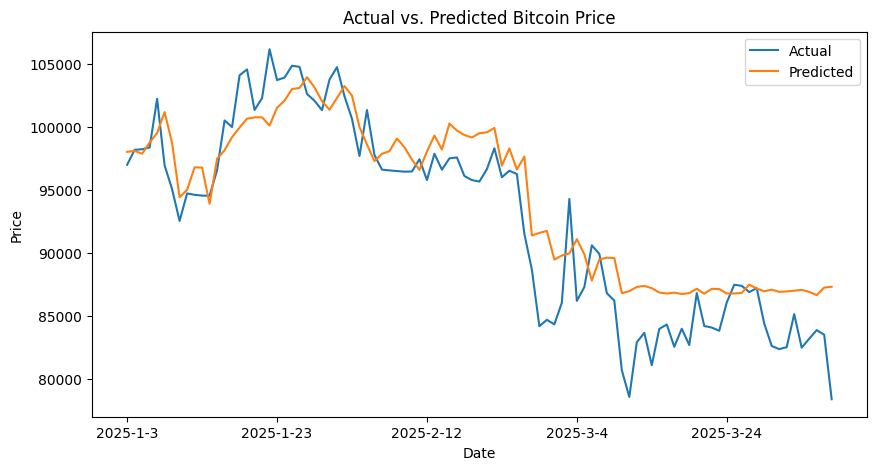

In [50]:
plot = pd.DataFrame({'Actual': y_test['BTC_USDT_1h_open'], 'Predicted': y_pred})
plot.plot(figsize=(10,5), xlabel='Date', ylabel='Price', title='Actual vs. Predicted Bitcoin Price')

In [51]:
from sklearn.metrics import mean_squared_error

In [52]:
np.sqrt(mean_squared_error(y_test, y_pred))

np.float64(3250.5228810146837)